In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Brain_tumor_large/"
IMG_SIZE = 331  
BATCH_SIZE = 32 
EPOCHS = 30
CLASS_NAMES = ['no', 'yes']

In [ ]:
def create_image_dataframe(data_path):
    image_paths = []
    labels = []

    for class_name in CLASS_NAMES:
        class_dir = os.path.join(data_path, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            image_paths.append(img_path)
            labels.append(class_name)

    return pd.DataFrame({'filepath': image_paths, 'label': labels})

df = create_image_dataframe(DATA_PATH)

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
def create_datagen(preprocess_input, augmentation=False):
    if augmentation:
        return ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.9, 1.1]
        )
    else:
        return ImageDataGenerator(preprocessing_function=preprocess_input)

preprocess_input = applications.nasnet.preprocess_input

train_datagen = create_datagen(preprocess_input, augmentation=True)
val_datagen = create_datagen(preprocess_input)
test_datagen = create_datagen(preprocess_input)

def create_flow(datagen, dataframe, shuffle=False):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='filepath',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=shuffle,
        classes=CLASS_NAMES
    )

train_generator = create_flow(train_datagen, train_df, shuffle=True)
val_generator = create_flow(val_datagen, val_df)
test_generator = create_flow(test_datagen, test_df)


Found 2100 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.


In [ ]:
def create_nasnet_model():
    base_model = applications.NASNetLarge(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False  

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

model = create_nasnet_model()


343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_nasnet.h5', save_best_only=True),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6897 - loss: 0.6709 - precision: 0.6679 - recall: 0.6923

66/66 ━━━━━━━━━━━━━━━━━━━━ 657s 9s/step - accuracy: 0.6907 - loss: 0.6686 - precision: 0.6693 - recall: 0.6933 - val_accuracy: 0.8822 - val_loss: 0.2995 - val_precision: 0.8413 - val_recall: 0.9422 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8836 - loss: 0.2838 - precision: 0.8708 - recall: 0.9035

66/66 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8836 - loss: 0.2836 - precision: 0.8710 - recall: 0.9034 - val_accuracy: 0.9267 - val_loss: 0.2166 - val_precision: 0.9068 - val_recall: 0.9511 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9002 - loss: 0.2420 - precision: 0.9058 - recall: 0.8883 - val_accuracy: 0.8711 - val_loss: 0.2798 - val_precision: 0.9771 - val_recall: 0.7600 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9165 - loss: 0.2083 - precision: 0.9260 - recall: 0.9075

66/66 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9166 - loss: 0.2081 - precision: 0.9259 - recall: 0.9078 - val_accuracy: 0.9489 - val_loss: 0.1524 - val_precision: 0.9764 - val_recall: 0.9200 - learning_rate: 0.0010
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9355 - loss: 0.1593 - precision: 0.9425 - recall: 0.9300

66/66 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9355 - loss: 0.1595 - precision: 0.9424 - recall: 0.9300 - val_accuracy: 0.9556 - val_loss: 0.1521 - val_precision: 0.9858 - val_recall: 0.9244 - learning_rate: 0.0010
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9496 - loss: 0.1408 - precision: 0.9501 - recall: 0.9486 - val_accuracy: 0.9356 - val_loss: 0.1763 - val_precision: 0.8920 - val_recall: 0.9911 - learning_rate: 0.0010
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9557 - loss: 0.1349 - precision: 0.9509 - recall: 0.9608

66/66 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9558 - loss: 0.1349 - precision: 0.9510 - recall: 0.9607 - val_accuracy: 0.9667 - val_loss: 0.1176 - val_precision: 0.9646 - val_recall: 0.9689 - learning_rate: 0.0010
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9616 - loss: 0.1028 - precision: 0.9615 - recall: 0.9618

66/66 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9616 - loss: 0.1029 - precision: 0.9615 - recall: 0.9618 - val_accuracy: 0.9689 - val_loss: 0.1018 - val_precision: 0.9528 - val_recall: 0.9867 - learning_rate: 0.0010
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9570 - loss: 0.1152 - precision: 0.9585 - recall: 0.9543 - val_accuracy: 0.9489 - val_loss: 0.1447 - val_precision: 0.9139 - val_recall: 0.9911 - learning_rate: 0.0010
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9651 - loss: 0.0989 - precision: 0.9586 - recall: 0.9706

66/66 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9652 - loss: 0.0987 - precision: 0.9587 - recall: 0.9706 - val_accuracy: 0.9756 - val_loss: 0.0897 - val_precision: 0.9820 - val_recall: 0.9689 - learning_rate: 0.0010
Epoch 11/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9666 - loss: 0.1022 - precision: 0.9647 - recall: 0.9672 - val_accuracy: 0.9622 - val_loss: 0.1072 - val_precision: 0.9444 - val_recall: 0.9822 - learning_rate: 0.0010
Epoch 12/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9718 - loss: 0.0821 - precision: 0.9714 - recall: 0.9734 - val_accuracy: 0.9689 - val_loss: 0.0928 - val_precision: 0.9567 - val_recall: 0.9822 - learning_rate: 0.0010
Epoch 13/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9670 - loss: 0.0840 - precision: 0.9651 - recall: 0.9688

66/66 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9670 - loss: 0.0840 - precision: 0.9651 - recall: 0.9689 - val_accuracy: 0.9711 - val_loss: 0.0807 - val_precision: 0.9649 - val_recall: 0.9778 - learning_rate: 0.0010
Epoch 14/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9718 - loss: 0.0723 - precision: 0.9756 - recall: 0.9698

66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9718 - loss: 0.0725 - precision: 0.9755 - recall: 0.9698 - val_accuracy: 0.9733 - val_loss: 0.0806 - val_precision: 0.9819 - val_recall: 0.9644 - learning_rate: 0.0010
Epoch 15/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9670 - loss: 0.0887 - precision: 0.9695 - recall: 0.9640 - val_accuracy: 0.9556 - val_loss: 0.1219 - val_precision: 0.9289 - val_recall: 0.9867 - learning_rate: 0.0010
Epoch 16/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9653 - loss: 0.0878 - precision: 0.9545 - recall: 0.9772 - val_accuracy: 0.9533 - val_loss: 0.1319 - val_precision: 1.0000 - val_recall: 0.9067 - learning_rate: 0.0010
Epoch 17/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9739 - loss: 0.0756 - precision: 0.9863 - recall: 0.9613

66/66 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9740 - loss: 0.0754 - precision: 0.9862 - recall: 0.9615 - val_accuracy: 0.9800 - val_loss: 0.0688 - val_precision: 0.9821 - val_recall: 0.9778 - learning_rate: 1.0000e-04
Epoch 18/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9851 - loss: 0.0513 - precision: 0.9862 - recall: 0.9837

66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9851 - loss: 0.0513 - precision: 0.9862 - recall: 0.9837 - val_accuracy: 0.9822 - val_loss: 0.0670 - val_precision: 0.9822 - val_recall: 0.9822 - learning_rate: 1.0000e-04
Epoch 19/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9873 - loss: 0.0444 - precision: 0.9935 - recall: 0.9814 - val_accuracy: 0.9778 - val_loss: 0.0720 - val_precision: 0.9736 - val_recall: 0.9822 - learning_rate: 1.0000e-04
Epoch 20/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9816 - loss: 0.0558 - precision: 0.9765 - recall: 0.9863 - val_accuracy: 0.9800 - val_loss: 0.0703 - val_precision: 0.9779 - val_recall: 0.9822 - learning_rate: 1.0000e-04
Epoch 21/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9880 - loss: 0.0507 - precision: 0.9884 - recall: 0.9870 - val_accuracy: 0.9756 - val_loss: 0.0756 - val_precision: 0.9693 - val_recall: 0.9822 - learning_rate: 1.0000e-04
Epoch 22/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accura

15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.9796 - loss: 0.0453 - precision: 0.9759 - recall: 0.9837

Test Accuracy: 0.9778
Test Loss: 0.0481
Precision: 0.9736
Recall: 0.9822
15/15 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step

Classification Report:
              precision    recall  f1-score   support

          no       0.98      0.97      0.98       225
         yes       0.97      0.98      0.98       225

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



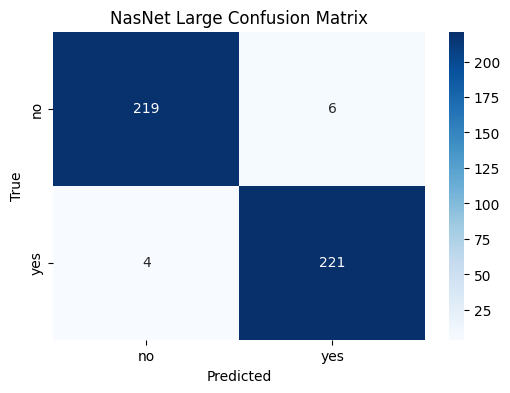

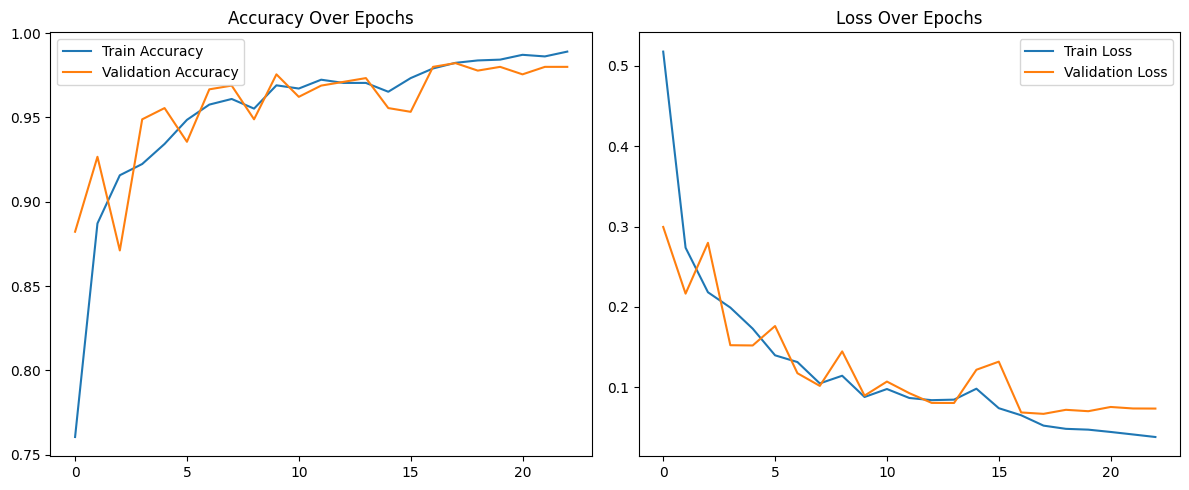

In [ ]:
model.load_weights('best_nasnet.h5')

test_results = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_results[1]:.4f}")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")

y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('NasNet Large Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()